# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record


## The problem I am going to solve
<b>From above:</b> Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type.<br>
Not only will I do that using a machine learning model, I will save the model, and provide an example of how it could be used in production

### Let's begin

In [2]:
#--Import section--------------------------------------------
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import json
import datetime
import statsmodels.api as sm
import sklearn as sk
import joblib

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from joblib import dump, load

%matplotlib inline

In [35]:
print('pandas version: {}'.format(pd.__version__))
print('numpy version: {}'.format(np.__version__))
#print('matplotlib version: {}'.format(plt.__version__))
#print('math version: {}'.format(math.__version__))
print('json version: {}'.format(json.__version__))
#print('datetime version: {}'.format(datetime.__version__))
print('statsmodel version: {}'.format(sm.__version__))
print('sklearn version: {}'.format(sk.__version__))
print('joblib version: {}'.format(joblib.__version__))

pandas version: 0.25.1
numpy version: 1.16.5
json version: 2.0.9
statsmodel version: 0.10.1
sklearn version: 0.21.3
joblib version: 0.13.2


In [3]:
#--Read in the base data sets--------------------------------
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

### Portfolio

In [4]:
#--Lets get a basic idea about the portfolio data------------
portfolio.info(), portfolio.head(2)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 6 columns):
reward        10 non-null int64
channels      10 non-null object
difficulty    10 non-null int64
duration      10 non-null int64
offer_type    10 non-null object
id            10 non-null object
dtypes: int64(3), object(3)
memory usage: 608.0+ bytes


(None,
    reward                      channels  difficulty  duration offer_type  \
 0      10       [email, mobile, social]          10         7       bogo   
 1      10  [web, email, mobile, social]          10         5       bogo   
 
                                  id  
 0  ae264e3637204a6fb9bb56bc8210ddfd  
 1  4d5c57ea9a6940dd891ad53e9dbe8da0  )

In [5]:
#--Split out the channels column into seperate ones----------
channels = pd.Series(portfolio['channels']).apply(frozenset).to_frame(name='channel')

for channel in frozenset.union(*channels.channel):
    channels[channel] = channels.apply(lambda _: int(channel in _.channel), axis=1)
    
port_c = portfolio.join(channels).drop(columns=['channels','channel']).rename(columns={'id':'offer_id'})
port_c = port_c[['offer_id','offer_type','web','social','email','mobile','reward','difficulty','duration']].sort_values(['offer_type','duration','reward'])
port_c

,offer_id,offer_type,web,social,email,mobile,reward,difficulty,duration
8,f19421c1d4aa40978ebb69ca19b0e20d,bogo,1,1,1,1,5,5,5
1,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,1,1,1,1,10,10,5
3,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,1,0,1,1,5,5,7
0,ae264e3637204a6fb9bb56bc8210ddfd,bogo,0,1,1,1,10,10,7
9,2906b810c7d4411798c6938adc9daaa5,discount,1,0,1,1,2,10,7
5,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,1,1,1,1,3,7,7
6,fafdcd668e3743c1bb461111dcafc2a4,discount,1,1,1,1,2,10,10
4,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,1,0,1,0,5,20,10
7,5a8bc65990b245e5a138643cd4eb9837,informational,0,1,1,1,0,0,3
2,3f207df678b143eea3cee63160fa8bed,informational,1,0,1,1,0,0,4


### Transcript

In [6]:
#--Lets get a basic idea about the transcript data---------
def find_unique_transcript_keys(transcript=transcript):
    '''
    INPUT: defaulted transcript data frame
    OUTPUT: unique_value_keys - a unique list of the transcript value column dictionary keys
    '''
    unique_value_keys = []

    for item in transcript['value'].items():
        l=list(item[1].keys())
        for i in range(len(l)):
            if l[i] not in unique_value_keys:
                unique_value_keys.append(l[i])

    return unique_value_keys

print("unique events: {}".format(transcript['event'].unique()))
print("unique transcript keys: {}".format(find_unique_transcript_keys()))
print("max time (days): {}\n".format(transcript['time'].max() / 24))
print(transcript.info())
print('\n')
print(transcript.head(2))

unique events: ['offer received' 'offer viewed' 'transaction' 'offer completed']
unique transcript keys: ['offer id', 'amount', 'offer_id', 'reward']
max time (days): 29.75

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 4 columns):
person    306534 non-null object
event     306534 non-null object
value     306534 non-null object
time      306534 non-null int64
dtypes: int64(1), object(3)
memory usage: 9.4+ MB
None


                             person           event  \
0  78afa995795e4d85b5d9ceeca43f5fef  offer received   
1  a03223e636434f42ac4c3df47e8bac43  offer received   

                                              value  time  
0  {'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}     0  
1  {'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}     0  


In [7]:
#--Transcript cleaning section-------------------------------
trans_c = transcript.join(pd.get_dummies(transcript['event'])).drop(columns='event') #get dummies for event column
trans_c = trans_c.join(pd.DataFrame(trans_c['value'].values.tolist(), index=trans_c.index)).drop(columns='value') #get dummies for value column
trans_c['offer_id'] = trans_c['offer id'].fillna('') + trans_c['offer_id'].fillna('') #merge the offer id columns
trans_c.drop(columns=['offer id'], inplace=True) #drop offer_id (was used for rewards)
trans_c.fillna({'amount':0, 'reward':0}, inplace=True) #fill the nans for amount and reward

<b>Question:</b> Can a person have more than one active offer at a time?

<b>Answer:</b> Yes, the below case shows both offer: ae264e3637204a6fb9bb56bc8210ddfd and f19421c1d4aa40978ebb69ca19b0e20d active at the same time
<br>The interesting part is that f19421c1d4aa40978ebb69ca19b0e20d was only viewed <i>after</i> being completed

In [8]:
#Lets look at only one person and see what we find
trans_c[trans_c['person']=='78afa995795e4d85b5d9ceeca43f5fef']

,person,time,offer completed,offer received,offer viewed,transaction,amount,offer_id,reward
0,78afa995795e4d85b5d9ceeca43f5fef,0,0,1,0,0,0.00,9b98b8c7a33c4b65b9aebfe6a799e6d9,0.0
15561,78afa995795e4d85b5d9ceeca43f5fef,6,0,0,1,0,0.00,9b98b8c7a33c4b65b9aebfe6a799e6d9,0.0
47582,78afa995795e4d85b5d9ceeca43f5fef,132,0,0,0,1,19.89,,0.0
47583,78afa995795e4d85b5d9ceeca43f5fef,132,1,0,0,0,0.00,9b98b8c7a33c4b65b9aebfe6a799e6d9,5.0
49502,78afa995795e4d85b5d9ceeca43f5fef,144,0,0,0,1,17.78,,0.0
53176,78afa995795e4d85b5d9ceeca43f5fef,168,0,1,0,0,0.00,5a8bc65990b245e5a138643cd4eb9837,0.0
85291,78afa995795e4d85b5d9ceeca43f5fef,216,0,0,1,0,0.00,5a8bc65990b245e5a138643cd4eb9837,0.0
87134,78afa995795e4d85b5d9ceeca43f5fef,222,0,0,0,1,19.67,,0.0
92104,78afa995795e4d85b5d9ceeca43f5fef,240,0,0,0,1,29.72,,0.0
141566,78afa995795e4d85b5d9ceeca43f5fef,378,0,0,0,1,23.93,,0.0


### Profile

In [9]:
#--Lets get an understanding of the profile data-------------
print('---info------------------------------------')
print(profile.info())
print('\n---head------------------------------------\n')
print(profile.head(2))
print('\n---Other stats-----------------------------\n')
print('incomplete profiles:\n{}%\n'.format(round(profile.isna().sum() / len(profile),3)*100))
print('\n---Uniques---------------------------------\n')
print('# ids: {}\n'.format(len(profile['id'].unique())))
print('Gender: {}\nGender value counts:'.format(profile['gender'].unique()))
print(profile['gender'].value_counts())
print('\nAge: {}\n'.format(profile['age'].unique()))
print('income: {}\n'.format(profile['income'].unique()))

---info------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 5 columns):
gender              14825 non-null object
age                 17000 non-null int64
id                  17000 non-null object
became_member_on    17000 non-null int64
income              14825 non-null float64
dtypes: float64(1), int64(2), object(2)
memory usage: 664.2+ KB
None

---head------------------------------------

  gender  age                                id  became_member_on    income
0   None  118  68be06ca386d4c31939f3a4f0e3dd783          20170212       NaN
1      F   55  0610b486422d4921ae7d2bf64640c50b          20170715  112000.0

---Other stats-----------------------------

incomplete profiles:
gender              12.8
age                  0.0
id                   0.0
became_member_on     0.0
income              12.8
dtype: float64%


---Uniques---------------------------------

# ids: 17000

Gender: [None 'F' 'M' 'O']


<b>Thought:</b> With a 12.8% incomplete profile, I want a bit better understanding before deciding how to handle them

In [10]:
profile['incomplete'] = profile['gender'].isna() # mark incomplete profiles for easier processing
profile['became_member_on'] = pd.to_datetime(profile['became_member_on'], format='%Y%m%d', errors='ignore') # Turn the becane member on into a date

mean_age = round(profile[profile['incomplete']==False]['age'].mean(),1)
mean_income = round(profile[profile['incomplete']==False]['income'].mean(),2)

print('Mean valid age: {}'.format(mean_age))
print('Median valid age: {}'.format(round(profile[profile['incomplete']==False]['age'].median(),1)))
print('Mean valid income: {}'.format(mean_income))
print('Median valid income: {}'.format(round(profile[profile['incomplete']==False]['income'].median(),2)))
print('Earliest member join date: {}'.format(profile['became_member_on'].min()))
print('Latest member join date: {}'.format(profile['became_member_on'].max()))

Mean valid age: 54.4
Median valid age: 55.0
Mean valid income: 65404.99
Median valid income: 64000.0
Earliest member join date: 2013-07-29 00:00:00
Latest member join date: 2018-07-26 00:00:00


C:\Users\cwalk834\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:4: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  after removing the cwd from sys.path.


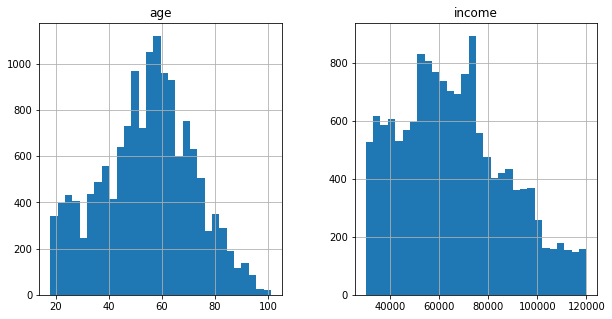

In [11]:
#--Plot age and income frequencies--------------------------
fig = plt.figure(figsize = (10,5))
ax = fig.gca()
profile[profile['incomplete']==False].hist(column=['age','income'],bins=30,ax=ax);

<b>Thought:</b> on age:<br>
There is an interesting age distribution here, with a heavier middle age than I would have suspected<br>
I am glad not to see any data collected on minors, as that would raise ethical concerns<br>
<br>
<b>Thought:</b>on income:<br>
Income distribution is about what I would suspect from offhand knowledge of US averages. no suprises here<br><br>
Now lets add gender into the equation<br>
If there are noticable differences, we will have to drop the unfilled records as we cannot properly/accurately infer the gender with the information at hand

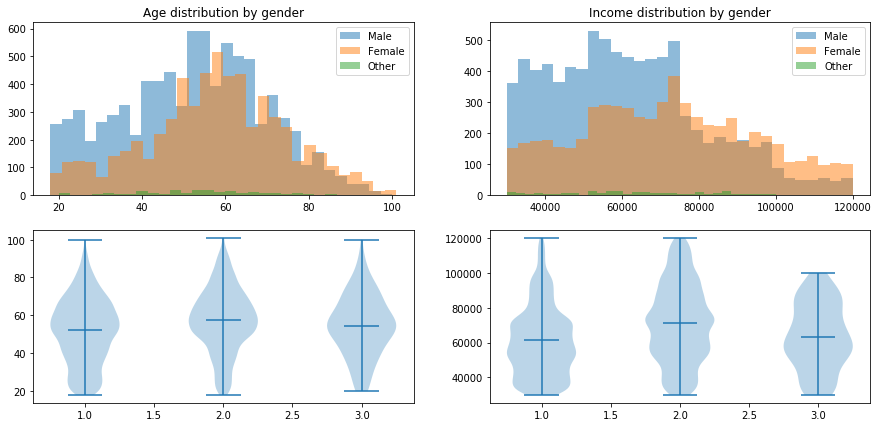

In [12]:
#--Plot age and income by gender----------------------------------------------------------
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15,7))
ax0, ax1, ax2, ax3 = axes.flatten()

genders = {'M':'Male','F':'Female','O':'Other'}

def getPlotValues(gender,col):
    ''' Returns the gender values to plot from the profile dataframe
    INPUT: gender: gender to plot
        col: The column of values to return (age or income in this case)
    OUTPUT: an array containing the chosen values
    '''
    return profile.loc[profile['gender']==gender][col].values

for k in genders.keys():
    ax0.hist(getPlotValues(k,'age'), bins=30, label=genders[k], alpha=0.5)
    ax1.hist(getPlotValues(k,'income'), bins=30, label=genders[k], alpha=0.5)

ax0.legend(prop={'size': 10})
ax0.set_title('Age distribution by gender')

ax1.legend(prop={'size': 10})
ax1.set_title('Income distribution by gender')

ax2.violinplot((getPlotValues('M','age'),
               getPlotValues('F','age'),
               getPlotValues('O','age')), showmeans=True);

ax3.violinplot((getPlotValues('M','income'),
               getPlotValues('F','income'),
               getPlotValues('O','income')), showmeans=True);

In [13]:
profile.loc[profile['gender']=='M']['age'].values

array([68, 65, 58, ..., 60, 61, 49], dtype=int64)

<b>Thought:</b> Since there are obvious differences between the genders, we will need to drop incomplete profiles from our analysis

C:\Users\cwalk834\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:24: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared


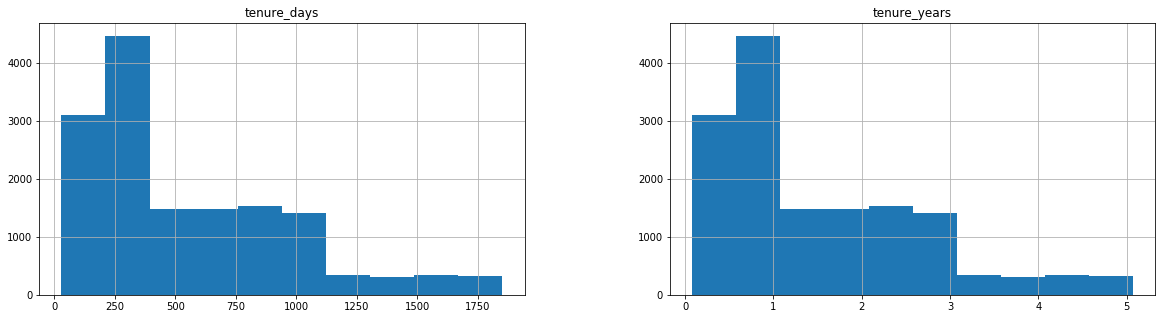

In [14]:
# Lets perform a little cleaning prior to adding tenure days
prof_c = profile[profile['incomplete']==False].copy().drop(columns=('incomplete'))
prof_c = prof_c.rename(columns={'id':'person','became_member_on':'join_date'})[['person','join_date','age','income','gender']]

# get the last transaction day
last_transaction_day = math.ceil(trans_c.time.max() / 24)

last_members_to_join = prof_c[prof_c['join_date']==prof_c['join_date'].max()][['person','join_date']]
last_members_to_join = last_members_to_join.merge(trans_c.groupby(['person'])['time'].max().reset_index().rename(columns={'time':'last_trans'}), how='left',left_on='person',right_on='person')
last_members_to_join.head()
last_members_to_join['last_trans_dt'] = last_members_to_join['join_date'] + pd.DateOffset(days=last_members_to_join['last_trans'].max()/24)

# This relative date will be used for tenure grouping
# !There is no absolute way of determining the real data collection date but that is in essence arbitrary
# I am using the maximum transaction date from the latest people to obtain a membership. 
data_collection_date = last_members_to_join['last_trans_dt'].max()

#Calculate tenure days, then drop the join date as it is no longer needed
prof_c['tenure_days'] = (data_collection_date - prof_c['join_date']).dt.days
prof_c['tenure_years'] = prof_c['tenure_days'] / 365

fig = plt.figure(figsize = (20,5))
ax = fig.gca()
prof_c.hist(column=['tenure_days','tenure_years'] ,bins=10,ax=ax);

There is a pretty clear distinction using tenure years. We're going to keep that one and drop the days

In [15]:
# Drop uneeded columns
prof_c.drop(columns=['tenure_days','join_date'],inplace=True)

### Create a person - offer dataset

In [16]:
# get hour the offer was recieved
df_offers = trans_c[trans_c['offer_id']!=''].groupby(['person','offer_id'])['time'].min().reset_index().rename(columns={'time':'hr_received'})
# get hour the offer was viewed
df_offers = df_offers.merge(trans_c[trans_c['offer viewed']==1].groupby(['person','offer_id'])['time'].min().reset_index().rename(columns={'time':'hr_viewed'}), how='left')
# get the hour the offer was completed
df_offers = df_offers.merge(trans_c[trans_c['offer completed']==1].groupby(['person','offer_id'])['time'].max().reset_index().rename(columns={'time':'hr_completed'}), how='left')
# get duration, then calculate hour the offer would end
df_offers = df_offers.merge(port_c[['offer_id','duration']], how='inner',left_on='offer_id',right_on='offer_id')
df_offers['hr_end'] = df_offers['hr_received'] + (df_offers['duration'] * 24)

In [17]:
#Add in influence start and end times
def infl_start(row):
    ''' Calculates the influence start hour of an offer
    INPUT: row of a dataframe (df_offers)
    OUTPUT: The hour the offer was viewed if it was viewed in time
    ''' 
    if (row['hr_viewed'] < row['hr_completed']) & (row['hr_viewed'] <= row['hr_end']) & (pd.isna(row['hr_completed'])==False):
        return row['hr_viewed']
    elif (row['hr_viewed'] <= row['hr_end']):
        return row['hr_viewed']
    return np.nan

def infl_end(row):
    ''' Calculates the influence end hour of an offer
    INPUT: the row of a dataframe (df_offers)
    OUTPUT: The hour the offer was completed or when it ends, depending on circumstances
    '''
    if row['hr_completed'] < row['hr_end']:
        return row['hr_completed'] + .99
    else:
        return row['hr_end'] + .99
    
df_offers = df_offers.assign(infl_start=df_offers.apply(lambda row: infl_start(row), axis=1).values)
df_offers = df_offers.dropna(subset=['infl_start']) #remove items where the offer never influenced the customer

df_offers = df_offers.assign(infl_end=df_offers.apply(lambda row: infl_end(row), axis=1).values)
df_offers.head()

,person,offer_id,hr_received,hr_viewed,hr_completed,duration,hr_end,infl_start,infl_end
3,0069a50874d846438e58acff5e594725,2906b810c7d4411798c6938adc9daaa5,504,552.0,696.0,7,672,552.0,672.99
4,00715b6e55c3431cb56ff7307eb19675,2906b810c7d4411798c6938adc9daaa5,504,564.0,534.0,7,672,564.0,534.99
7,0092a132ead946ceb30d11a1ed513d20,2906b810c7d4411798c6938adc9daaa5,576,582.0,NaN,7,744,582.0,744.99
8,0099bf30e4cb4265875266eb3eb25eab,2906b810c7d4411798c6938adc9daaa5,504,576.0,NaN,7,672,576.0,672.99
9,009d10c2c38a4fd795a7bc6ddbbddb78,2906b810c7d4411798c6938adc9daaa5,504,552.0,NaN,7,672,552.0,672.99


### Build purchases dataset including offer influences and profile information

In [18]:
purchases = trans_c[trans_c['transaction']==1][['person','time','amount']].reset_index().rename(columns={'index':'trans_id'})
pur_off = purchases.merge(df_offers[['person','offer_id','infl_start','infl_end']])

def influenced_by(row):
    ''' Calcualtes the offer a purchase was influenced by
    INPUT: row of a dataframe (pur_off)
    OUTPUT: the offer_id the purchase was influenced by when applicable
    '''
    if (row['time'] >= row['infl_start']) & (row['time'] <= row['infl_end']):
        return row['offer_id']
    return 'none'

pur_off = pur_off.assign(influenced_by=pur_off.apply(lambda row: influenced_by(row), axis=1).values)
purchases = purchases.merge(pur_off[pur_off['influenced_by']!='none'][['trans_id','influenced_by']], how='left').fillna('none')

# Drop duplicate transactions caused by overlapping offers. The first offer is considered the valid one here, and the second merely a bonus
# The difference was 978 of 139,931 or 0.61%
purchases.drop_duplicates(subset='trans_id', inplace=True)

purchases = purchases.merge(port_c, how='left', left_on='influenced_by', right_on='offer_id') # join portfolio information

purchases.drop(columns=['trans_id','offer_id','influenced_by'], inplace=True)
purchases['offer_type'].fillna('none', inplace=True)
purchases.fillna(0, inplace=True)

purchases = prof_c.merge(purchases, how='inner') # merge profile information
purchases = purchases.join(pd.get_dummies(purchases['gender'], prefix='gender')) # get dummies for gender for linear regression analysis
purchases = purchases.join(pd.get_dummies(purchases['offer_type'], prefix='offer')) # get dummies for gender for linear regression analysis

purchases.head()

,person,age,income,gender,tenure_years,time,amount,offer_type,web,social,...,reward,difficulty,duration,gender_F,gender_M,gender_O,offer_bogo,offer_discount,offer_informational,offer_none
0,0610b486422d4921ae7d2bf64640c50b,55,112000.0,F,1.109589,18,21.51,none,0.0,0.0,...,0.0,0.0,0.0,1,0,0,0,0,0,1
1,0610b486422d4921ae7d2bf64640c50b,55,112000.0,F,1.109589,144,32.28,none,0.0,0.0,...,0.0,0.0,0.0,1,0,0,0,0,0,1
2,0610b486422d4921ae7d2bf64640c50b,55,112000.0,F,1.109589,528,23.22,none,0.0,0.0,...,0.0,0.0,0.0,1,0,0,0,0,0,1
3,78afa995795e4d85b5d9ceeca43f5fef,75,100000.0,F,1.293151,132,19.89,bogo,1.0,0.0,...,5.0,5.0,7.0,1,0,0,1,0,0,0
4,78afa995795e4d85b5d9ceeca43f5fef,75,100000.0,F,1.293151,144,17.78,none,0.0,0.0,...,0.0,0.0,0.0,1,0,0,0,0,0,1


### Linear regression on transaction amount for deeper understanding

In [19]:
print(purchases['gender'].value_counts())
print(purchases['offer_type'].value_counts())
print('Web: {}, social: {}, email: {}, mobile: {}'.format(purchases['web'].sum(),purchases['social'].sum(),purchases['email'].sum(),purchases['mobile'].sum()))

M    72794
F    49382
O     1781
Name: gender, dtype: int64
none             71367
bogo             23049
discount         21833
informational     7708
Name: offer_type, dtype: int64
Web: 39849.0, social: 41174.0, email: 52590.0, mobile: 50147.0


In [20]:
def linear_model_summary(df,target):
    ''' Generates a linear regression of a dataframe, then prints the summary
    INPUT: df: DataFrame (purchases subset)
        target: The target column for the Linear Regression
    OUTPUT: none. Prints the Linear Regression model summary
    '''
    X = df.drop(columns=target)
    y = df[target]
    model = sm.OLS(y,X).fit()
    predictions = model.predict(X)
    print(model.summary())

# We will user Male & offer_none & email as our intercept as they are the most common
df_l = purchases.drop(columns=['person','time','gender','offer_type','gender_M','offer_none', 'email'])
linear_model_summary(df_l,'amount')

                                 OLS Regression Results                                
Dep. Variable:                 amount   R-squared (uncentered):                   0.210
Model:                            OLS   Adj. R-squared (uncentered):              0.210
Method:                 Least Squares   F-statistic:                              2357.
Date:                Sun, 03 May 2020   Prob (F-statistic):                        0.00
Time:                        20:53:02   Log-Likelihood:                     -6.0089e+05
No. Observations:              123957   AIC:                                  1.202e+06
Df Residuals:                  123943   BIC:                                  1.202e+06
Df Model:                          14                                                  
Covariance Type:            nonrobust                                                  
                          coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------

<b>Thought:</b> That's not a very promising regression, let's try cleaning up our variables

In [21]:
def custom_round(x, base=5):
    ''' Rounds a dataframe column to the nearest base number. 5 is default
    INPUT: X: the value to be rounded
    OUTPUT: the integer rounded number
    '''
    return int(base * round(float(x)/base))

# Drop the insufficient predictors, and rewards, as that would be a direct driver of amount spent
df_l = purchases.drop(columns=['person','time','gender','offer_type','gender_M','offer_none', 'email','web','mobile','social','gender_F','gender_O','offer_bogo','offer_discount','offer_informational','reward']).copy()
df_l['age'] = df_l['age'].apply(lambda x: custom_round(x, base=5)) #Group age by 5
df_l['income'] = (df_l['income'] / 10000).astype(int) #Bucket income by 10,000s
df_l = df_l.round({'tenure_years':0}) #round tenure years to solid years
df_l.rename(columns={'income':'income_10000'}, inplace=True)

linear_model_summary(df_l,'amount')

                                 OLS Regression Results                                
Dep. Variable:                 amount   R-squared (uncentered):                   0.208
Model:                            OLS   Adj. R-squared (uncentered):              0.208
Method:                 Least Squares   F-statistic:                              6527.
Date:                Sun, 03 May 2020   Prob (F-statistic):                        0.00
Time:                        20:53:02   Log-Likelihood:                     -6.0104e+05
No. Observations:              123957   AIC:                                  1.202e+06
Df Residuals:                  123952   BIC:                                  1.202e+06
Df Model:                           5                                                  
Covariance Type:            nonrobust                                                  
                   coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------

<b>Thought:</b> Although cleaned up, and slightly useful, I think we will get a better grasp on the data after looking at some general summarizations<br>
<b>Insights: on average, and everything else being equal..</b>
<ul>
    <li>The older someone is, the less they are inclined to spend, however minutely
    <li>People that have higher incomes spend more</li>
    <li>The longer someone is a member, then less they will spend. That has a higher error then we would normally like though</li>
    <li>The greater the difficulty of the offer, the larger the spend</li>
    <li>The longer the duration of the reward, the less the amount spent. This also has a slightly higher error then I would normally tolerate</li>
</ul>

### Purchase and amount per day by demographics

In [22]:
# Add the influence hours column to the offer_details DataFrame
pers_summary = prof_c.copy()
offer_details = df_offers.merge(port_c)

def infl_hrs(row):
    ''' calculate the actual influencing hours for a given offer
    INPUT: dataframe (offer_details) row
    OUTPUT: the influence end - start or 0 when it would result in a negative number
    '''
    if row['infl_end'] > row['infl_start']:
        return row['infl_end'] - row['infl_start']
    return 0

offer_details = offer_details.assign(infl_hrs=offer_details.apply(lambda row: infl_hrs(row), axis=1).values)

In [23]:
# Create a person summary dataframe (df_persOffer) for use in charting and further investigation

# Add influence hours, Purchases influenced, Purchase amount influenced by offer type
df_persOffer = prof_c.join(offer_details.groupby(['person','offer_type'])['infl_hrs'].sum().unstack(fill_value=0).add_prefix('infl_hrs_'), on='person')
df_persOffer = df_persOffer.join(purchases.groupby(['person','offer_type'])['time'].count().unstack(fill_value=0).add_prefix('purchase_infl_'), on='person')
df_persOffer = df_persOffer.join(purchases.groupby(['person','offer_type'])['amount'].sum().unstack(fill_value=0).add_prefix('purchase_infl_amt_'), on='person')
df_persOffer = df_persOffer.fillna(0)

# Calculate the hours where a person wasn't influenced by an offer
df_persOffer['infl_hrs_none'] = (30*24) - (df_persOffer['infl_hrs_bogo'] + df_persOffer['infl_hrs_discount'] + df_persOffer['infl_hrs_informational'])
df_persOffer.drop(df_persOffer[df_persOffer['infl_hrs_none']==720].index, inplace=True) # drop records that were never influenced by an offer

strTypes = ['none','bogo','discount','informational']

# for each type of offer, calculate purchases and amount per day, then the change from not being influenced
for strType in strTypes:
    df_persOffer['purch_per_day_'+strType] = df_persOffer['purchase_infl_' + strType] / (df_persOffer['infl_hrs_'+strType] / 24)
    df_persOffer['purch_amt_per_day'+strType] = df_persOffer['purchase_infl_amt_' + strType] / (df_persOffer['infl_hrs_'+strType] / 24)
    
    if strType != 'none':
        df_persOffer['purch_per_day_delta_'+strType] = df_persOffer['purch_per_day_'+strType] - df_persOffer['purch_per_day_none']
        df_persOffer['purch_amt_per_day_delta_'+strType] = df_persOffer['purchase_infl_amt_' + strType] - df_persOffer['purchase_infl_amt_none']
        
        idx = df_persOffer[(df_persOffer['purch_per_day_none'] > 0) & (df_persOffer['purch_per_day_'+strType] > 0)].index
        df_persOffer.loc[idx,'purch_per_day_delta_percentage_'+strType] = df_persOffer.loc[idx,'purch_per_day_delta_'+strType] / df_persOffer.loc[idx,'purchase_infl_none']
        df_persOffer.loc[idx,'purch_amt_per_day_delta_percentage_'+strType] = df_persOffer.loc[idx,'purch_amt_per_day_delta_'+strType] / df_persOffer.loc[idx,'purchase_infl_amt_none']

df_persOffer.head()

,person,age,income,gender,tenure_years,infl_hrs_bogo,infl_hrs_discount,infl_hrs_informational,purchase_infl_bogo,purchase_infl_discount,...,purch_per_day_delta_discount,purch_amt_per_day_delta_discount,purch_per_day_delta_percentage_discount,purch_amt_per_day_delta_percentage_discount,purch_per_day_informational,purch_amt_per_dayinformational,purch_per_day_delta_informational,purch_amt_per_day_delta_informational,purch_per_day_delta_percentage_informational,purch_amt_per_day_delta_percentage_informational
3,78afa995795e4d85b5d9ceeca43f5fef,75,100000.0,F,1.293151,229.98,0.00,24.99,2.0,0.0,...,NaN,-68.27,NaN,NaN,1.920768,47.433373,1.765940,-18.88,0.588647,-0.276549
5,e2127556f4f64592b11af22de27a7932,68,70000.0,M,0.328767,102.99,151.98,0.00,0.0,1.0,...,0.054696,-20.89,0.027348,-0.531417,NaN,NaN,NaN,-39.31,NaN,NaN
8,389bc3fa690240e798340f5a15918d5c,65,53000.0,M,0.536986,265.98,157.98,0.00,1.0,2.0,...,0.303836,26.89,NaN,NaN,NaN,NaN,NaN,0.00,NaN,NaN
12,2eeac8d8feae4a8cad5a6af0499a211d,58,51000.0,M,0.783562,0.00,277.98,0.00,0.0,3.0,...,0.204715,13.88,0.204715,15.954023,NaN,NaN,NaN,-0.87,NaN,NaN
13,aa4862eba776480b8bb9c68455b8c2e1,61,57000.0,F,0.950685,61.98,222.99,72.99,1.0,1.0,...,-0.157536,-48.33,-0.039384,-0.796736,0.000000,0.000000,-0.265164,-60.66,NaN,NaN


C:\Users\cwalk834\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\lib\histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\cwalk834\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\lib\histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


bogo offers:
	# people influenced: 11488
	# people who increase their transaction rate: 7849 or 68% of those influenced
	# people who increase their spending per day: 1863 or 16% of those influenced
	# people who increase their spending and transactions: 1795 or 15% of those influenced

discount offers:
	# people influenced: 10315
	# people who increase their transaction rate: 7372 or 71% of those influenced
	# people who increase their spending per day: 1892 or 18% of those influenced
	# people who increase their spending and transactions: 1726 or 16% of those influenced

informational offers:
	# people influenced: 6409
	# people who increase their transaction rate: 3537 or 55% of those influenced
	# people who increase their spending per day: 576 or 8% of those influenced
	# people who increase their spending and transactions: 574 or 8% of those influenced



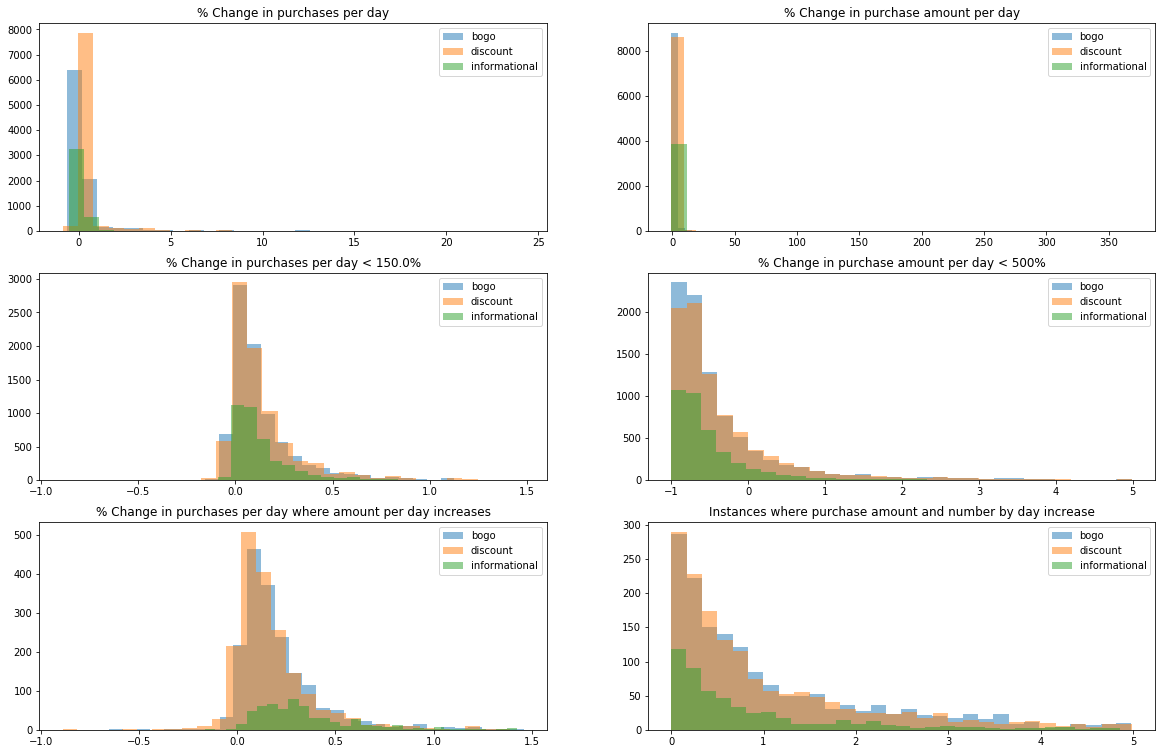

In [24]:
def purch_per_day_values(strType, max=1000, df=df_persOffer):
    ''' Generates an array of the purchases per day for the chosen offer type
    INPUT: strType: Offer type (bogo, discount, informational)
        Max (optional): The value must be below the max to be returned. Used to limit output and focus on a subset
        df (optional): DataFrame the values are obtained from (defaults to df_persOffer)
    OUTPUT:
    '''
    if max==1000:
        return df['purch_per_day_delta_percentage_'+strType].values
    else:
        return df[df['purch_per_day_delta_percentage_'+strType]<max]['purch_per_day_delta_percentage_'+strType].values

def purch_amt_per_day_values(strType, max=1000, df=df_persOffer):
    ''' Generates an array of the purchase amount per day for the chosen offer type
    INPUT: strType: Offer type (bogo, discount, informational)
        Max (optional): The value must be below the max to be returned. Used to limit output and focus on a subset
        df (optional): DataFrame the values are obtained from (defaults to df_persOffer)
    OUTPUT:
    '''
    if max==1000:
        return df['purch_amt_per_day_delta_percentage_'+strType].values
    else:
        return df[df['purch_amt_per_day_delta_percentage_'+strType]<max]['purch_amt_per_day_delta_percentage_'+strType].values
    
def purch_per_day_where_amt_positive(strType, max=1000, df=df_persOffer):
    ''' Generates an array of the purchases per day where the purchase amount per day increases, for the chosen offer type
    INPUT: strType: Offer type (bogo, discount, informational)
        Max (optional): The value must be below the max to be returned. Used to limit output and focus on a subset
        df (optional): DataFrame the values are obtained from (defaults to df_persOffer)
    OUTPUT:
    '''
    return df[(df['purch_amt_per_day_delta_percentage_'+strType]>0) & (df['purch_per_day_delta_percentage_'+strType]<max)]['purch_per_day_delta_percentage_'+strType].values
    
def purch_amt_per_day_where_num_positive(strType, max=1000, df=df_persOffer):
    ''' Generates an array of the purchase amounts per day where the number of purchases also increases, for the chosen offer type
    INPUT: strType: Offer type (bogo, discount, informational)
        Max (optional): The value must be below the max to be returned. Used to limit output and focus on a subset
        df (optional): DataFrame the values are obtained from (defaults to df_persOffer)
    OUTPUT:
    '''
    return df[(df['purch_amt_per_day_delta_percentage_'+strType]<max) 
              & (df['purch_per_day_delta_percentage_'+strType] > 0)
             & (df['purch_amt_per_day_delta_percentage_'+strType]>0)]['purch_amt_per_day_delta_percentage_'+strType].values

# Set the variables needed for the hist charts
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(20,13))
ax0, ax1, ax2, ax3, ax4, ax5 = axes.flatten()

legend_size = 10
purch_max = 1.5
purch_amt_max = 5

def drawHist(ax, values, label, bins=30, alpha=0.5):
    ''' Draws the histogram values on a given axes
    INPUT: ax: axes to be drawn on
        values: An array of the values to be drawn
        label: The histogram label
        bins (optional): sets the histogram number of bins
        alpha (optional): sets the histogram alpha component
    OUTPUT: None
    '''
    ax.hist(values, bins=bins, label=strType, alpha=alpha)
    
def finalizeChart(ax, title, legend_size=10):
    ''' Finalizes any remaining items for the chart (ie. Title, legend)4
    INPUT: ax: axes object
        title: The title of the chart
        legend_size (optional): The size of the legend
    OUTPUT: None
    '''
    ax.legend(prop={'size': legend_size})
    ax.set_title(title)
    
# For each type of offer, plot a series of 6 charts, but use the same bins # and alpha attributes
for strType in strTypes[1:]:
    drawHist(ax0,purch_per_day_values(strType),strType)
    drawHist(ax1,purch_amt_per_day_values(strType),strType)
    drawHist(ax2,purch_per_day_values(strType,purch_max),strType)
    drawHist(ax3,purch_amt_per_day_values(strType, purch_amt_max),strType)
    drawHist(ax4,purch_per_day_where_amt_positive(strType, purch_max),strType)
    drawHist(ax5,purch_amt_per_day_where_num_positive(strType,purch_amt_max),strType)
    
    people_inc_transactions = len(df_persOffer[df_persOffer['purch_per_day_delta_percentage_'+strType]>0])
    people_inc_amount = len(df_persOffer[df_persOffer['purch_amt_per_day_delta_percentage_'+strType]>0])
    people_inc_both = len(purch_amt_per_day_where_num_positive(strType))
    people_influenced = len(df_persOffer[df_persOffer['infl_hrs_'+strType]>0])
    
    print('{} offers:'.format(strType))
    print('\t# people influenced: {}'.format(people_influenced))
    print('\t# people who increase their transaction rate: {} or {}% of those influenced'.format(people_inc_transactions,int((people_inc_transactions/people_influenced)*100)))
    print('\t# people who increase their spending per day: {} or {}% of those influenced'.format(people_inc_amount,int((people_inc_amount/people_influenced)*100)))
    print('\t# people who increase their spending and transactions: {} or {}% of those influenced\n'.format(people_inc_both,int((people_inc_both/people_influenced)*100)))
    
finalizeChart(ax0,'% Change in purchases per day')
finalizeChart(ax1,'% Change in purchase amount per day')
finalizeChart(ax2,'% Change in purchases per day < ' + str(purch_max * 100) + '%')
finalizeChart(ax3,'% Change in purchase amount per day < '+ str(purch_amt_max * 100) + '%')
finalizeChart(ax4,'% Change in purchases per day where amount per day increases')
finalizeChart(ax5,'Instances where purchase amount and number by day increase')

<b>Thought:</b> Each type of offer is not always effective, and may be effective at influencing more transactions per day, but with a lower purchase amount per day

### Random forest classifier
Lets see if we can predict what offers would lead to higher average purchase amounts per day by demographic

In [25]:
# Create a new purchase summary dataset that includes all the details
groupbyCols = ['person','age','income','gender','tenure_years','web','social','email','mobile','reward','difficulty','duration','offer_type']
df_sum = purchases.groupby(groupbyCols)['time'].count().reset_index().rename(columns=({'time':'purchases'}))
df_sum = df_sum.merge(purchases.groupby(groupbyCols)['amount'].sum().reset_index())

#Calculate average purchase amount and add to df_sum
df_sum['avg_purch_amt'] = df_sum['amount'] / df_sum['purchases']
df_sum = df_sum.merge(offer_details[offer_details['infl_hrs']>0].groupby(['person','offer_type','web','social','email','mobile','reward','difficulty'])['infl_hrs'].sum().reset_index(),how='left')

# Add in offer_type none influence hours
none_sum = df_persOffer[['person','infl_hrs_none']].rename(columns=({'infl_hrs_none':'infl_hrs'}))
none_sum['offer_type']='none'
df_sum = df_sum.merge(none_sum, how='left', on=['person','offer_type'])

#Clean up the dataframe then add in amount per day none so we can calculate amount per day increases field
df_sum['infl_hrs_x'].fillna(df_sum['infl_hrs_y'], inplace=True)
df_sum = df_sum.rename(columns={'infl_hrs_x':'infl_hrs'}).drop(columns='infl_hrs_y')
df_sum['amt_per_day'] = (df_sum['infl_hrs'] / 24) / df_sum['amount']
df_sum = df_sum.merge(df_sum[df_sum['offer_type']=='none'][['person','amt_per_day']].rename(columns={'amt_per_day':'amt_per_day_none'}), how='left', on='person')
df_sum['amt_per_day_increases'] = df_sum['amt_per_day'] > df_sum['amt_per_day_none']

# get dummy columns and remove uneeded columns and rows
df_sum = df_sum[df_sum['offer_type']!='none']
df_sum = df_sum.join(pd.get_dummies(df_sum['gender'], prefix='gender')).drop(columns='gender')
df_sum = df_sum.join(pd.get_dummies(df_sum['offer_type'], prefix='offer')).drop(columns='offer_type') 
df_sum.drop(columns=['avg_purch_amt', 'infl_hrs', 'amt_per_day', 'amt_per_day_none','purchases', 'amount','person'], inplace=True)

# Simplify some features
df_sum['age'] = df_sum['age'].apply(lambda x: custom_round(x, base=5)) #Group age by 5
df_sum['income'] = (df_sum['income'] / 10000).astype(int) #Bucket income by 10,000s

In [26]:
def save_model(model, model_filepath):
    ''' Saves the model as a pkl file
    INPUT: model: The model object to be saved
        model_filepath: The file path to save the object
    OUTPUT: None
    '''
    dump(model, model_filepath)

def display_results(y_test, y_pred, strType):
    ''' Displays the models results
        INPUT: y_test: the actual outcomes from the test set
            y_pred: the predicted outcomes of the test set
            strType: The offer type predicted (bogo, discount, informational)
        OUTPUT: none, it only prints the results
    '''
    actual_labels = y_test.value_counts()
    labels = np.unique(y_pred)
    confusion_mat = confusion_matrix(y_test, y_pred, labels=labels)
    accuracy = str(round((y_pred == y_test).mean(),4)*100)[:5]
    
    print(str(strType+'------------------------------')[:20])
    print("Labels: ", labels)
    print("Confusion Matrix: ", confusion_mat)
    print("Accuracy: {}%".format(accuracy))
    print('--------------------')
    
def create_RF_model(X_train,y_train, X_test):
    ''' creates a Random Forest Model
    INPUT: X_train: the training attribute values
        y_train: the training target values
        X_test: the testing attibute values
    OUTPUT: RF: a Random Forest model
        y_pred: An arrary of the predicted values
    '''
    RF = RandomForestClassifier(n_estimators=100, max_depth=4, random_state=0, class_weight='balanced')
    RF.fit(X_train, y_train)
    y_pred = RF.predict(X_test)
    return RF, y_pred
    
# Build the models and report the outcome
# This was used as a test set. At first I had not included the "class_weight" attribute of the RandomForestClassifier, 
# and this code helped me figure out my mistake (by printing the labels specifically)
attr = ['age', 'income', 'tenure_years', 'gender_M', 'gender_F', 'reward', 'difficulty', 'duration', 'amt_per_day_increases']
target = 'amt_per_day_increases'

# Loop through the offer types and generate some models
for strType in strTypes[1:]:
    df = df_sum[df_sum['offer_'+strType]==1][attr]
    X = df.drop(columns=target)
    y = df[target]
    X_train, X_test, y_train, y_test = train_test_split(X, y)
    
    RF, y_pred = create_RF_model(X_train,y_train, X_test)
    display_results(y_test,y_pred,strType)
    feature_importances = pd.DataFrame(list(RF.feature_importances_) ,index = X_train.columns, columns=['importance']).sort_values('importance', ascending=False)
    print('\nFeature importances')
    print(feature_importances)
    print('\n')

bogo----------------
Labels:  [False  True]
Confusion Matrix:  [[1535 1130]
 [ 197  302]]
Accuracy: 58.06%
--------------------

Feature importances
              importance
income          0.401466
tenure_years    0.238795
age             0.146679
duration        0.072167
gender_M        0.041798
difficulty      0.035787
gender_F        0.034251
reward          0.029058


discount------------
Labels:  [False  True]
Confusion Matrix:  [[1526  918]
 [ 230  258]]
Accuracy: 60.85%
--------------------

Feature importances
              importance
tenure_years    0.341260
income          0.245384
age             0.148286
duration        0.077776
gender_M        0.065082
gender_F        0.059124
difficulty      0.046612
reward          0.016476


informational-------
Labels:  [False  True]
Confusion Matrix:  [[515 406]
 [ 68  85]]
Accuracy: 55.87%
--------------------

Feature importances
              importance
tenure_years    0.351800
income          0.341907
age             0.181653
dur

<b>Thought:</b> Building a Random Forest model on everything will not be as accurate as we could be. Lets see how we can improve it...<br>
I had originally made a compliated mess of figuring out how to select the best Random Forest model. I had used a powerset of every possible combination of features, and it turns out I should have just looked at the variable importances. If you're curious about how I went about it, the removed code is included in the "removed_powerset_code.ipynb"<br><br>
<b>Thought:</b> let's use the variable importances, rebuild the models and save them

In [27]:
def build_and_save_model(strType,attributes):
    ''' Build a Random Forest model, print some summary information, and then save the model
    INPUT: strType: offer type (bogo, discount, informational)
        attributes: The attributes to be used as a list
    OUTPUT: the generated Random Forest model
    '''
    df = df_sum[df_sum['offer_'+strType]==1][all_attributes].copy()
    y = df[target]
    X = df[attributes]
    X_train, X_test, y_train, y_test = train_test_split(X, y)
    mdl, y_pred = create_RF_model(X_train,y_train,X_test)
    save_model(mdl, ".\\models\\"+strType+"_RandomForest_Model.pkl")
    
    feature_importances = pd.DataFrame(list(mdl.feature_importances_) ,index = X_train.columns, columns=['importance']).sort_values('importance', ascending=False)
    
    print('Model for {} offers'.format(strType))
    print('accuracy: {}'.format((y_pred == y_test).mean()*100))
    print('offers to: {}% of customers\n'.format(round(y_pred.mean()*100,2)))
    print('Variable importance\n',feature_importances)
    print('\n')
    return mdl

all_attributes = ['age', 'income', 'tenure_years', 'gender_M', 'gender_F', 'gender_O', 'reward', 'difficulty', 'duration', 'web','social','email','mobile','amt_per_day_increases']

# Set the feature lists to be used for each offer type
bogo_features = ['income','tenure_years','age','duration','gender_M','gender_F','difficulty','reward']
discount_features = ['tenure_years','income','age','duration','gender_F','difficulty','gender_M','reward',]
informational_features = ['tenure_years','income','age','duration','gender_M',]

featureSets = {'bogo':bogo_features
           ,'discount':discount_features
           ,'informational':informational_features}

# build a model for each offer type
b_mdl = build_and_save_model('bogo',bogo_features)
d_mdl = build_and_save_model('discount',discount_features)
i_mdl = build_and_save_model('informational',informational_features)

Model for bogo offers
accuracy: 57.585335018963335
offers to: 44.66% of customers

Variable importance
               importance
income          0.380962
tenure_years    0.212122
duration        0.123133
age             0.115820
difficulty      0.047242
reward          0.046718
gender_M        0.043891
gender_F        0.030113


Model for discount offers
accuracy: 59.515688949522506
offers to: 41.68% of customers

Variable importance
               importance
tenure_years    0.419245
income          0.237080
age             0.121338
gender_F        0.057393
gender_M        0.055821
duration        0.049935
difficulty      0.036520
reward          0.022668


Model for informational offers
accuracy: 53.910614525139664
offers to: 47.11% of customers

Variable importance
               importance
tenure_years    0.347693
income          0.297572
age             0.207476
duration        0.101848
gender_M        0.045411




### Model use example
The following code is an illustration of how you could use the models in practice<br>
You could build a web app, or run customer lists through them, then filter on those that<br>
are predicted to increase their purchase per day rate, and schedule the offers accordingly

In [28]:
# Load the models
bogo_model = joblib.load(".\\models\\bogo_RandomForest_Model.pkl")
discount_model = joblib.load(".\\models\\discount_RandomForest_Model.pkl")
informational_model = joblib.load(".\\models\\informational_RandomForest_Model.pkl")

def predict_offer_outcome(df):
    ''' Predicts whether customers will increase their spending amount per day for the various offers
    INPUT: a customer DataFrame that contains all attributes needed for all models
    OUTPUT: prediction arrays for the loaded customers for each offer type
    '''
    #subset dataframes by offer
    df_bogo = df[featureSets['bogo']]
    df_discount = df[featureSets['discount']]
    df_informational = df[featureSets['informational']]
    
    #make the predictions
    bogo_pred = bogo_model.predict(df_bogo)
    discount_pred = discount_model.predict(df_discount)
    informational_pred = informational_model.predict(df_informational)
    return bogo_pred, discount_pred, informational_pred

#This example is for a single person
lpb, lpd, lpi = predict_offer_outcome(df_sum.loc[1234].to_frame().transpose())
lpb[0], lpd[0], lpi[0]

(False, True, False)

In [29]:
#This example is the entire dataset, then I add in the predictions back to it
df_sumWithPreds = df_sum.copy()
lpb, lpd, lpi = predict_offer_outcome(df_sumWithPreds)
df_sumWithPreds['predicted_bogo'] = list(lpb)
df_sumWithPreds['predicted_discount'] = list(lpd)
df_sumWithPreds['predicted_informational'] = list(lpi)
df_sumWithPreds.head()

,age,income,tenure_years,web,social,email,mobile,reward,difficulty,duration,amt_per_day_increases,gender_F,gender_M,gender_O,offer_bogo,offer_discount,offer_informational,predicted_bogo,predicted_discount,predicted_informational
1,35,7,1.342466,0.0,1.0,1.0,1.0,0.0,0.0,3.0,False,0,1,0,0,0,1,False,False,False
2,35,7,1.342466,1.0,0.0,1.0,1.0,0.0,0.0,4.0,True,0,1,0,0,0,1,False,False,True
4,40,5,0.621918,1.0,0.0,1.0,0.0,5.0,20.0,10.0,False,0,0,1,0,1,0,True,True,True
5,40,5,0.621918,1.0,1.0,1.0,1.0,3.0,7.0,7.0,False,0,0,1,0,1,0,True,True,True
7,60,9,2.473973,1.0,1.0,1.0,1.0,2.0,10.0,10.0,False,1,0,0,0,1,0,False,False,False


### Review top demographics for offer influence
Lets review our top performing demographics for each type of offer<br>
Threshold: at least 20% of a demographic must see an increase in average purchase amount over time<br>
Both income and Tenure were identified as important in all three offer types, so we will focus on them<br>
I had tried including age, but that narrowed things down to person by person, too granular for this step 

In [132]:
# Clean a few features up for more general analysis
df_c = df_sum.copy()
df_c['income'] = (df_c['income'] * 10000).astype(str) + ' to ' + ((df_c['income'] * 10000) + 9999).astype(str)
df_c['tenure_years'] = round(df_c['tenure_years'],0).astype(int)
df_c['Total people'] = 1

def set_offer_type(row):
    if row['offer_bogo']==1:
         return 'bogo'
    elif row['offer_discount']==1:
         return 'discount'
    elif row['offer_informational']==1:
        return 'informational'
    
df_c = df_c.assign(offer_type=df_c.apply(lambda row: set_offer_type(row), axis=1).values)
top_demographics = df_c.groupby(['offer_type','income','tenure_years'])['amt_per_day_increases'].mean().reset_index().sort_values('amt_per_day_increases', ascending=False)
top_demographics = top_demographics.merge(df_c.groupby(['offer_type','income','tenure_years'])['Total people'].sum(), how='left', left_on=['offer_type','income','tenure_years'], right_on=['offer_type','income','tenure_years'])
top_demographics['amt_per_day_increases'] = round(top_demographics['amt_per_day_increases'] * 100, 2)
top_demographics.rename(columns={'income':'Income','tenure_years':'Tenure yrs','offer_type':'Offer type','amt_per_day_increases':'% of people where spending increased'}, inplace=True)

# Although we could look at any percentage, lets focus on groupings with over 20% increase in the amount they spend
# and sort our results to more easily see ranges and trends
top_demographics[top_demographics['% of people where spending increased']>=20].sort_values(['Offer type', 'Income', 'Tenure yrs'])

,Offer type,Income,Tenure yrs,% of people where spending increased,Total people
0,bogo,100000 to 109999,4,50.00,2
9,bogo,30000 to 39999,0,23.96,338
13,bogo,30000 to 39999,1,22.77,786
15,bogo,30000 to 39999,5,22.22,81
17,bogo,40000 to 49999,0,21.82,307
22,bogo,40000 to 49999,5,20.78,77
12,bogo,50000 to 59999,0,22.85,337
25,bogo,50000 to 59999,4,20.42,142
21,bogo,60000 to 69999,0,20.78,308
16,bogo,60000 to 69999,4,22.22,135


### Conclusions
The dataset was pretty neat, and completing this project really reinforced a lot that I had learned in the Udacity course. I made the task more complicated than it needed to be, but ended up bringing it back around by using more efficient methods.<br>
Having the built in complications of incomplete data, not everyone gets the same or even any offers, alongside 3 similar but distinct offer types, made this a challenge similar to what I would expect in production. There are many different ways you could analyize this dataset, and I feel I could still do a ton more with it like:<br>
<ul>
    <li>Visualization of offer efficiency considering view source (web, social, etc), or other attributes like difficulty, or duration</li>
    <li>Questions like: does a shorter offer duration cause quicker purchases by the customer</li>
    <li>A time series run where you see if people purchase more frequently on a given day of the week, and how offers affect customer patterns</li>
</ul>
The main goal I chose, was to build something practical the company could use make their choices more efficient. Two of the forest models predict with slightly better accuracy then chance, and so they may be worth further exploration<br>
Reviewing the top performing demographics for amount spending increases shows some clustering, like discounts for incomes from 30,000 to 69,999 for 0 year tenured members, making company followup easier